In [1]:
import config
from bs4 import BeautifulSoup as BS
import mysql.connector
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import json
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import *
import time
import re
from surprise import SVD
from surprise import Dataset
from surprise.model_selection import cross_validate
from surprise import Reader
from surprise.model_selection import train_test_split
from surprise import accuracy
from surprise import KNNBasic
from surprise.model_selection import GridSearchCV

from sklearn.metrics.pairwise import cosine_similarity

In [2]:
df = pd.read_csv('updated_df.csv', index_col=0)

In [3]:
df.head()

,fit,user_id,bust_size,item_id,weight,rating,rented_for,review_text,body_type,review_summary,category,height,size,age,cup_size
0,fit,420272,34,2260466,137lbs,10.0,vacation,An adorable romper! Belt and zipper were a lit...,hourglass,So many compliments!,romper,68.0,14,28.0,d
1,fit,273551,34,153475,132lbs,10.0,other,I rented this dress for a photo shoot. The the...,straight & narrow,I felt so glamourous!!!,gown,66.0,12,36.0,b
3,fit,909926,34,126335,135lbs,8.0,formal affair,I rented this for my company's black tie award...,pear,Dress arrived on time and in perfect condition.,dress,65.0,8,34.0,c
4,fit,151944,34,616682,145lbs,10.0,wedding,I have always been petite in my upper body and...,athletic,Was in love with this dress !!!,gown,69.0,12,27.0,b
5,fit,734848,32,364092,138lbs,8.0,date,Didn't actually wear it. It fit perfectly. The...,athletic,Traditional with a touch a sass,dress,68.0,8,45.0,b


In [4]:
#### change weight column to drop 'lbs'
df['weight'] = df['weight'].str.split('\D+')
df['weight'] = df['weight'].apply(lambda x:x[0])
df['weight'] = df['weight'].astype('int32')

In [5]:
df.head()

,fit,user_id,bust_size,item_id,weight,rating,rented_for,review_text,body_type,review_summary,category,height,size,age,cup_size
0,fit,420272,34,2260466,137,10.0,vacation,An adorable romper! Belt and zipper were a lit...,hourglass,So many compliments!,romper,68.0,14,28.0,d
1,fit,273551,34,153475,132,10.0,other,I rented this dress for a photo shoot. The the...,straight & narrow,I felt so glamourous!!!,gown,66.0,12,36.0,b
3,fit,909926,34,126335,135,8.0,formal affair,I rented this for my company's black tie award...,pear,Dress arrived on time and in perfect condition.,dress,65.0,8,34.0,c
4,fit,151944,34,616682,145,10.0,wedding,I have always been petite in my upper body and...,athletic,Was in love with this dress !!!,gown,69.0,12,27.0,b
5,fit,734848,32,364092,138,8.0,date,Didn't actually wear it. It fit perfectly. The...,athletic,Traditional with a touch a sass,dress,68.0,8,45.0,b


In [6]:
### remove outlier from "rented_for" columns
condition2 = df['rented_for'] != 'party: cocktail'
df = df[condition2]

In [ ]:
df.head()

In [7]:
df.category.value_counts()

dress           70341
gown            33240
sheath          14679
shift            4032
jumpsuit         4016
                ...  
sweatershirt        3
sweatpants          1
crewneck            1
buttondown          1
overcoat            1
Name: category, Length: 68, dtype: int64

In [8]:
df.category.unique()

array(['romper', 'gown', 'dress', 'sheath', 'leggings', 'sweater',
       'jacket', 'shirtdress', 'jumpsuit', 'shift', 'top', 'shirt',
       'mini', 'skirt', 'maxi', 'pants', 'suit', 'coat', 'blouse',
       'trench', 'cape', 'bomber', 'blazer', 'vest', 'duster', 'ballgown',
       'tank', 'poncho', 'frock', 'tunic', 'cardigan', 'down', 'culottes',
       'midi', 'legging', 'print', 'pant', 'knit', 'culotte',
       'sweatshirt', 'peacoat', 'trouser', 'kaftan', 'overalls', 'jogger',
       'tee', 'combo', 'henley', 'blouson', 'pullover', 'turtleneck',
       'trousers', 'overcoat', 'hoodie', 't-shirt', 'caftan', 'tight',
       'kimono', 'cami', 'for', 'crewneck', 'skirts', 'parka',
       'buttondown', 'skort', 'sweatershirt', 'jeans', 'sweatpants'],
      dtype=object)

In [ ]:
df.head()

In [ ]:
df.columns

In [ ]:
df = df.rename(columns={'bust size': 'bust_size', 'rented for': 'rented_for', 'body type': 'body_type'})

In [ ]:
df.bust_size.value_counts()

In [ ]:
re.split('(\D+)', '34b')

In [ ]:
df['bust_size'] = df['bust_size'].str.split('(\D+)')

In [ ]:
df.head()

In [ ]:
df['cup_size'] = df.bust_size.str[1]

In [ ]:
df['bust_size'] = df.bust_size.str[0]

In [ ]:
#df = df.dropna()

In [ ]:
condition = df['height'] != 'nan'

In [ ]:
df = df[condition]

In [ ]:
def parse_ht(ht):
    # format: 7' 0.0"
    ht_ = ht.split("' ")
    ft_ = float(ht_[0])
    in_ = float(ht_[1].replace("\"",""))
    return (12*ft_) + in_

#print df["HeightNoShoes"].apply(lambda x:parse_ht(x))

In [ ]:
parse_ht("5' 8")

In [ ]:
df['height'] = df['height'].astype(str)

In [ ]:
df['height'] = df['height'].str.split('"')

In [ ]:
df['height'] = df['height'].apply(lambda x:x[0])

In [ ]:
df.height[0]

In [ ]:
df['height'] = df['height'].apply(lambda x:parse_ht(x))

In [ ]:
df.head()

In [ ]:
df.to_csv(r'/Users/andrewtriola/Documents/flatiron/mod_6_proj/mod_6_project/updated_df.csv')

In [9]:
corr_df = df.corr()

In [ ]:
df['rating'].value_counts()

(array([  778.,  2183.,  8309., 40670., 94196.]),
 array([ 2. ,  3.6,  5.2,  6.8,  8.4, 10. ]),
 <a list of 5 Patch objects>)

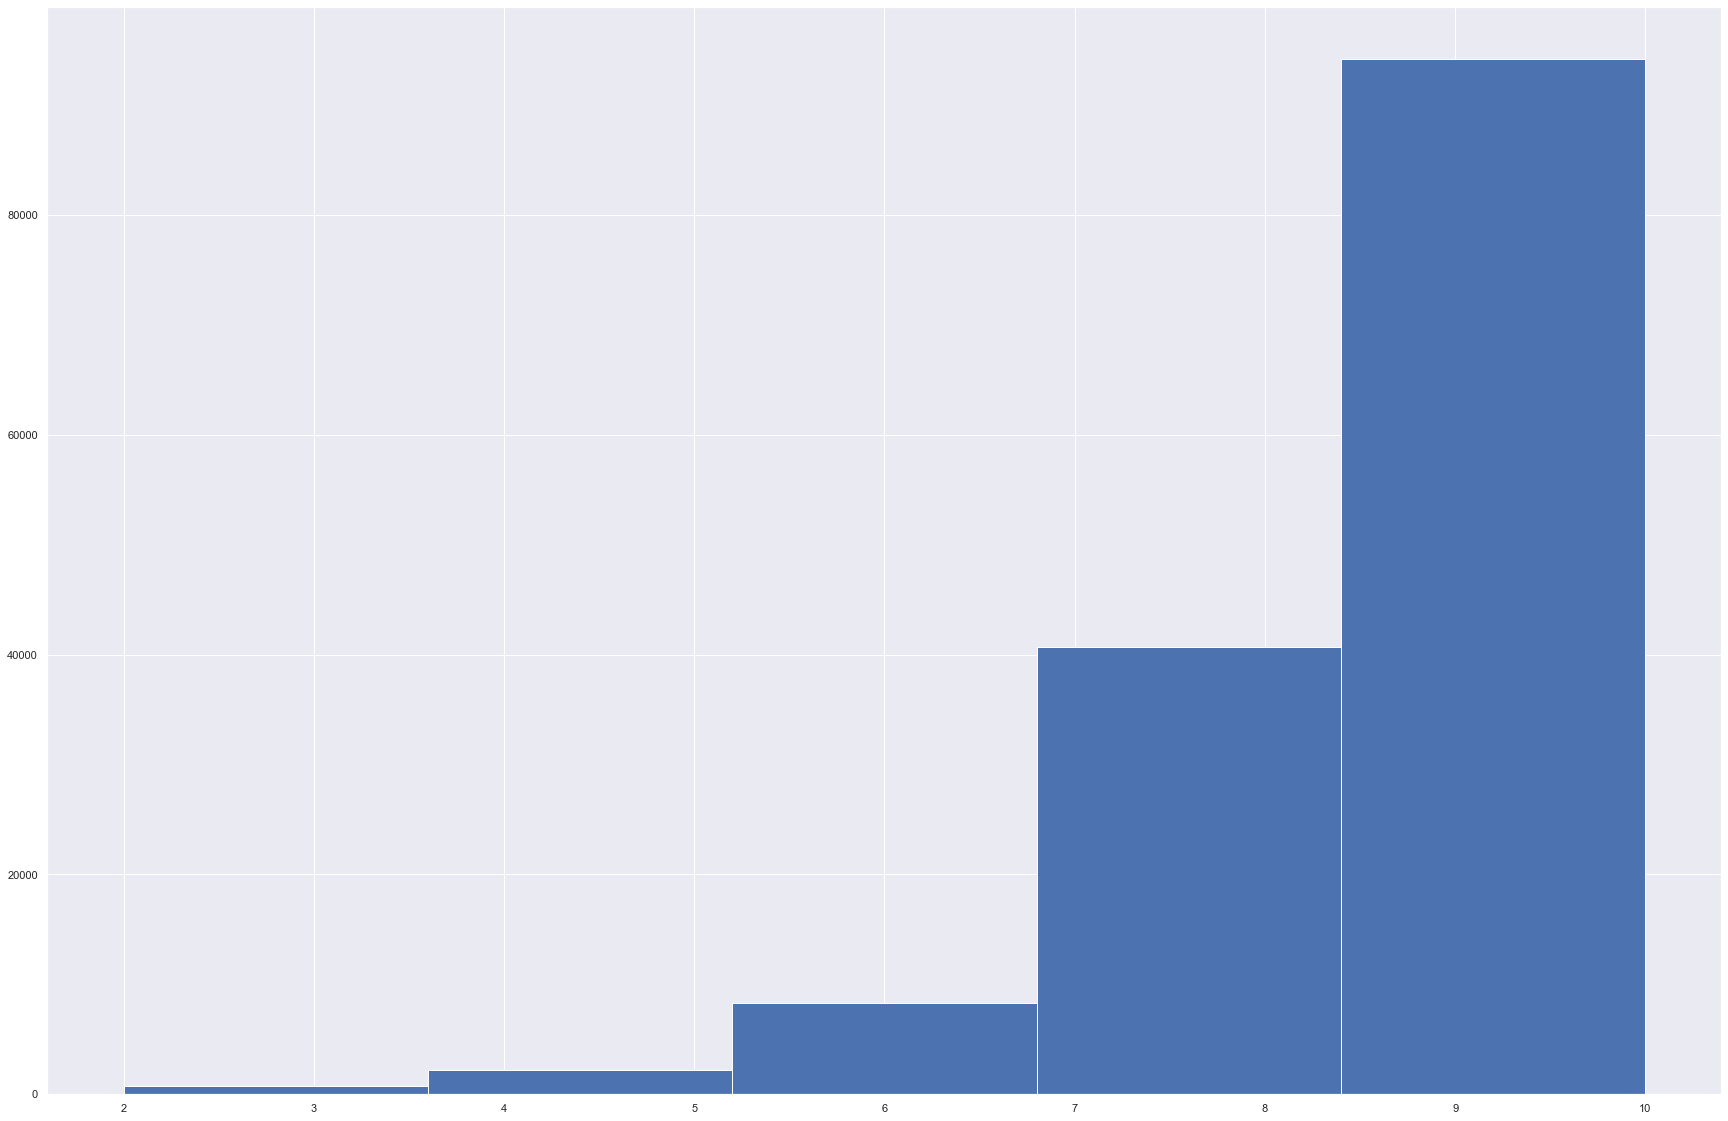

In [254]:
plt.hist(df['rating'], bins=5)

In [ ]:
df['weight']

In [ ]:
abc = re.split('\D+', '137lbs')[0]

In [ ]:
abc

In [ ]:
df['weight'] = df['weight'].str.split('\D+')

In [ ]:
df['weight'] = df['weight'].apply(lambda x:x[0])

In [ ]:
df['weight'] = df['weight'].astype('int32')

In [ ]:
df.head()

In [ ]:
df.to_csv(r'/Users/andrewtriola/Documents/flatiron/mod_6_proj/mod_6_project/updated_df2.csv')

In [ ]:
plt.hist(df['weight'], bins=25)

In [ ]:
df['user_id'].value_counts()

In [ ]:
condition1 = df['user_id'] == 45337

In [ ]:
condition2 = df['rented_for'] != 'party: cocktail'

In [ ]:
df = df[condition2]

In [ ]:
##regroup categories (reduce from 68 to 7)
recat1 = df.replace(['dress', 'sheath', 'shirtdress', 'shift', 'ballgown', 'frock', 'kaftan', 'caftan', 'gown', 'print'], 'dresses')
recat2 = recat1.replace(['romper', 'jumpsuit', 'overalls', 'combo', 'suit'], 'jumpsuits')
recat3 = recat2.replace(['jogger', 'trousers', 'tight', 'jeans', 'sweatpants', 'leggings', 'pants', 'culottes', 'legging', 'pant', 'culotte', 'trouser'], 'pants')
recat4 = recat3.replace(['sweater', 'duster', 'cardigan', 'sweatshirt', 'pullover', 'turtleneck', 'hoodie', 'sweatershirt'], 'sweaters')
recat5 = recat4.replace(['jacket', 'coat', 'trench', 'cape', 'bomber', 'blazer', 'vest', 'poncho', 'down', 'parka', 'peacoat', 'overcoat'], 'outerwear')
recat6 = recat5.replace(['top,', 'shirt', 'blouse', 'tank', 'tunic', 'knit', 'tee', 'henley', 'blouson', 't-shirt', 'kimono', 'cami', 'crewneck', 'buttondown', 'for'], 'tops')
recat7 = recat6.replace(['mini', 'skirt', 'maxi','midi', 'skirts', 'skort'], 'skirts')
recat8 = recat7.replace(['top'], 'tops')

##rename recategorized df variable
df = recat8

In [11]:
dress_condition = ((df['category'] == 'dress') | (df['category'] == 'sheath') | (df['category'] == 'shirtdress') | 
(df['category'] == 'shift') | (df['category'] == 'ballgown') | (df['category'] == 'frock') | 
(df['category'] == 'kaftan') | (df['category'] == 'caftan') | (df['category'] == 'gown') | (df['category'] == 'print'))

In [12]:
dress_df = df[dress_condition]

In [13]:
dress_df.head()

,fit,user_id,bust_size,item_id,weight,rating,rented_for,review_text,body_type,review_summary,category,height,size,age,cup_size
1,fit,273551,34,153475,132,10.0,other,I rented this dress for a photo shoot. The the...,straight & narrow,I felt so glamourous!!!,gown,66.0,12,36.0,b
3,fit,909926,34,126335,135,8.0,formal affair,I rented this for my company's black tie award...,pear,Dress arrived on time and in perfect condition.,dress,65.0,8,34.0,c
4,fit,151944,34,616682,145,10.0,wedding,I have always been petite in my upper body and...,athletic,Was in love with this dress !!!,gown,69.0,12,27.0,b
5,fit,734848,32,364092,138,8.0,date,Didn't actually wear it. It fit perfectly. The...,athletic,Traditional with a touch a sass,dress,68.0,8,45.0,b
6,fit,336066,34,568429,112,10.0,everyday,This dress is so sweet. I loved the print. The...,hourglass,LITERALLY THE CUTEST DRESS EVER,dress,63.0,4,27.0,c


In [ ]:
df.category.value_counts()

In [14]:
user_df = df[['user_id', 'bust_size', 'cup_size', 'body_type', 'weight', 'height', 'age']].copy()

In [15]:
item_df = df[['item_id', 'rating', 'rented_for', 'category']].copy()

In [16]:
dress_item_df = dress_df[['item_id', 'rating', 'rented_for', 'category']].copy()

In [ ]:
item_df.shape

In [ ]:
user_df.head()

In [22]:
ratings_df = small_df[['user_id', 'item_id', 'rating']]

In [23]:
dress_ratings_df = dress_df[['user_id', 'item_id', 'rating']]

In [ ]:
dress_ratings_df.head()

In [ ]:
# A reader is still needed but only the rating_scale param is requiered.
reader = Reader(rating_scale=(2.0, 10.0))

# The columns must correspond to user id, item id and ratings (in that order).
data = Dataset.load_from_df(dress_ratings_df, reader)

In [ ]:
# We'll use the famous SVD algorithm.
algo = SVD()

# Run 5-fold cross-validation and print results
cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

In [ ]:
# sample random trainset and testset
# test set is made of 25% of the ratings.
trainset, testset = train_test_split(data, test_size=.25)

In [ ]:
# We'll use the famous SVD algorithm.
algo = SVD()

# Train the algorithm on the trainset, and predict ratings for the testset
algo.fit(trainset)
predictions = algo.test(testset)

# Then compute RMSE
accuracy.rmse(predictions)

In [ ]:
### grid search ###

param_grid = {'n_epochs': [5, 10], 'lr_all': [0.002, 0.005],
              'reg_all': [0.4, 0.6]}
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3)

gs.fit(data)

# best RMSE score
print(gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

In [ ]:
###one hot encode item df
items_dummies = pd.get_dummies(item_df)
items_dummies.head()

In [ ]:
###one hot encode item df
dress_items_dummies = pd.get_dummies(dress_item_df)
dress_items_dummies.head()

In [ ]:
dress_items_dummies.shape

In [ ]:
# cosine_similarity(items_dummies)

In [ ]:
items_df_dress = dress_items_dummies.groupby(['item_id']).mean()

In [ ]:
df.groupby(['item_id']).item_id.count().sort_values(ascending = False).head(50)

In [19]:
df['item_count'] = df.groupby(['item_id'])['item_id'].transform('count')

In [ ]:
df.head()

In [20]:
condition3 = df['item_count'] < 20

In [ ]:
len((df[df['item_count'] < 20])['item_id'].unique())

In [21]:
small_df = df[condition3]

In [ ]:
items_df_dress.shape

In [ ]:
items_df_dress.head()

In [ ]:
cosine_similarity(items_df_dress)

In [ ]:
### make rec matrix for dress df

In [ ]:
dress_recs = dress_df[['user_id', 'item_id', 'rating']]

In [ ]:
reader = Reader(rating_scale=(2,10))
data = Dataset.load_from_df(dress_recs,reader)

In [ ]:
train, test = train_test_split(data,test_size=0.25)

In [ ]:
# We'll use the famous SVD algorithm.
algo = SVD()

# Train the algorithm on the trainset, and predict ratings for the testset
algo.fit(trainset)
predictions = algo.test(testset)

# Then compute RMSE
accuracy.rmse(predictions)

In [ ]:
### grid search ###

param_grid = {'n_epochs': [12,13], 'lr_all': [0.009, 0.01, 0.011],
              'reg_all': [0.35,0.4, 0.45]}
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3)

gs.fit(data)

# best RMSE score
print(gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

In [ ]:
# skipping
# cross validating with KNNBasic
knn_basic = KNNBasic(sim_options={'name':'pearson', 'user_based':True})
cv_knn_basic = cross_validate(knn_basic, data, n_jobs=-1)
for i in cv_knn_basic.items():
    print(i)
print('-----------------------')
print(np.mean(cv_knn_basic['test_rmse']))



In [ ]:
# cross validating with KNNBaseline
knn_baseline = KNNBaseline(sim_options={'name':'pearson', 'user_based':True})
cv_knn_baseline = cross_validate(knn_baseline,data)
for i in cv_knn_baseline.items():
    print(i)
np.mean(cv_knn_baseline['test_rmse'])

In [25]:
dress_df['item_count'] = dress_df.groupby(['item_id'])['item_id'].transform('count')

/Users/andrewtriola/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [26]:
condition4 = dress_df['item_count'] < 20

In [28]:
small_dress_df = dress_df[condition4]

In [45]:
dress_small_ratings_df = small_dress_df[['user_id', 'item_id', 'rating']]

In [146]:
dress_small_ratings_df.shape

(17737, 3)

In [46]:
reader = Reader(rating_scale=(2,10))
data = Dataset.load_from_df(dress_small_ratings_df,reader)

In [32]:
# skipping
# cross validating with KNNBasic
knn_basic = KNNBasic(sim_options={'name':'pearson', 'user_based':True})
cv_knn_basic = cross_validate(knn_basic, data, n_jobs=-1)
for i in cv_knn_basic.items():
    print(i)
print('-----------------------')
print(np.mean(cv_knn_basic['test_rmse']))



('test_rmse', array([1.49949173, 1.51515135, 1.52755969, 1.53797294, 1.537429  ]))
('test_mae', array([1.23950095, 1.25203504, 1.25227433, 1.25828419, 1.25664369]))
('fit_time', (20.733392000198364, 20.568089723587036, 20.11698579788208, 18.573551177978516, 5.321741104125977))
('test_time', (0.17890191078186035, 0.20891213417053223, 0.10373902320861816, 0.11112499237060547, 0.046755075454711914))
-----------------------
1.5235209408682269


In [34]:
# cross validating with KNNBaseline
from surprise.prediction_algorithms import KNNBaseline
knn_baseline = KNNBaseline(sim_options={'name':'pearson', 'user_based':True})
cv_knn_baseline = cross_validate(knn_baseline,data)
for i in cv_knn_baseline.items():
    print(i)
np.mean(cv_knn_baseline['test_rmse'])

Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
('test_rmse', array([1.49987156, 1.45807163, 1.46994754, 1.51157683, 1.48477858]))
('test_mae', array([1.20052122, 1.1659273 , 1.1856336 , 1.20520975, 1.18634309]))
('fit_time', (5.200239896774292, 5.399817943572998, 5.261378765106201, 5.1657209396362305, 5.300236225128174))
('test_time', (0.056257009506225586, 0.055994272232055664, 0.06219911575317383, 0.06447601318359375, 0.18319416046142578))


1.4848492272562706

In [37]:
# sample random trainset and testset
# test set is made of 25% of the ratings.
trainset, testset = train_test_split(data, test_size=.25)

In [38]:
# We'll use the famous SVD algorithm.
algo = SVD()

# Train the algorithm on the trainset, and predict ratings for the testset
algo.fit(trainset)
predictions = algo.test(testset)

# Then compute RMSE
accuracy.rmse(predictions)

RMSE: 1.4974


1.4974160703146928

In [48]:
dress_big_ratings_df = dress_df[['user_id', 'item_id', 'rating']]

In [50]:
dress_big_ratings_df.head()

,user_id,item_id,rating
1,273551,153475,10.0
3,909926,126335,8.0
4,151944,616682,10.0
5,734848,364092,8.0
6,336066,568429,10.0


In [51]:
# index=user columns=item values=rating
dress_recs = pd.pivot_table(dress_big_ratings_df, values='rating', index='user_id', columns='item_id')

In [56]:
similar = dress_recs.corrwith(dress_recs[126335])
corr_similar = pd.DataFrame(similar,columns=['correlation'])

In [57]:
corr_similar.head()

,correlation
item_id,
123373,-0.454545
123793,NaN
124204,0.133631
124553,NaN
125424,0.707107


In [63]:
def get_recs(item, n_recs=5):
    similar = dress_recs.corrwith(dress_recs[item])
    corr_similar = pd.DataFrame(similar,columns=['correlation'])
    corr_similar.dropna(inplace=True)
    
    orig = dress_big_ratings_df.copy()
    
    corr_with_item = pd.merge(
            left=corr_similar,
            right=orig,
            on='item_id')[['item_id', 'correlation']].drop_duplicates().reset_index(drop=True)
    
    result = corr_with_item.sort_values(by='correlation', ascending=False)
    
    return result.head(n_recs)

In [64]:
get_recs(126335, n_recs=20)

,item_id,correlation
44,167112,1.0
17,135459,1.0
5,126335,1.0
101,1209909,1.0
27,144727,1.0
39,156607,1.0
29,146684,1.0
33,149655,1.0
78,651557,1.0
42,164593,1.0


In [65]:
#### limit df to users and items with count > 1

In [67]:
dress_big_ratings_df.shape

(123136, 3)

In [68]:
dress_big_ratings_df['item_count'] = dress_big_ratings_df.groupby(['item_id'])['item_id'].transform('count')

/Users/andrewtriola/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [70]:
dress_big_ratings_df['user_count'] = dress_big_ratings_df.groupby(['user_id'])['user_id'].transform('count')

/Users/andrewtriola/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [72]:
dress_big_ratings_df.shape

(123136, 5)

In [216]:
condition_u = dress_big_ratings_df['user_count'] > 15
condition_i = dress_big_ratings_df['item_count'] > 15
condition_u2 = dress_big_ratings_df['user_count'] < 100
condition_i2 = dress_big_ratings_df['item_count'] < 100

In [198]:
#dress_ratings1 = dress_big_ratings_df[condition_u & condition_i & condition_i2 & condition_u2]
dress_ratings1 = dress_big_ratings_df[condition_u & condition_i]

In [217]:
len(dress_ratings1['item_id'].unique())

1399

In [218]:
len(dress_ratings1['user_id'].unique())

191

In [136]:
dress_recs2 = pd.pivot_table(dress_ratings1, values='rating', index='user_id', columns='item_id')

In [94]:
def get_recs2(item, n_recs=5):
    similar = dress_recs2.corrwith(dress_recs[item])
    corr_similar = pd.DataFrame(similar,columns=['correlation'])
    corr_similar.dropna(inplace=True)
    
    orig = dress_big_ratings_df.copy()
    
    corr_with_item = pd.merge(
            left=corr_similar,
            right=orig,
            on='item_id')[['item_id', 'correlation']].drop_duplicates().reset_index(drop=True)
    
    result = corr_with_item.sort_values(by='correlation', ascending=False)
    
    return result.head(n_recs)

In [121]:
similar = dress_recs2.corrwith(dress_recs[126335])
corr_similar = pd.DataFrame(similar,columns=['correlation'])

In [122]:
corr_similar.head()

,correlation
item_id,
123373,NaN
123793,NaN
124204,NaN
124553,NaN
125424,NaN


In [138]:
get_recs2(123373, n_recs=30)

/Users/andrewtriola/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2526: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/Users/andrewtriola/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


,item_id,correlation
0,247125,1.0
1,1339136,-1.0


In [201]:
dress_ratings1.shape

(3836, 5)

In [143]:
### train test split and SVD for dress_df

In [202]:
reader = Reader(rating_scale=(2,10))
data = Dataset.load_from_df(dress_ratings1[['user_id', 'item_id', 'rating']],reader)

In [203]:
# sample random trainset and testset
# test set is made of 25% of the ratings.
trainset, testset = train_test_split(data, test_size=.25)

In [204]:
# We'll use the famous SVD algorithm.
algo = SVD()

# Train the algorithm on the trainset, and predict ratings for the testset
algo.fit(trainset)
predictions = algo.test(testset)

# Then compute RMSE
accuracy.rmse(predictions)

RMSE: 1.2961


1.2960860289120573

In [205]:
predictions[20:40]

[Prediction(uid=380920, iid=1009546, r_ui=10.0, est=9.701903433625178, details={'was_impossible': False}),
 Prediction(uid=377223, iid=786827, r_ui=10.0, est=8.843881049025523, details={'was_impossible': False}),
 Prediction(uid=313140, iid=590893, r_ui=10.0, est=9.314480417411751, details={'was_impossible': False}),
 Prediction(uid=275108, iid=727157, r_ui=10.0, est=8.862111389284959, details={'was_impossible': False}),
 Prediction(uid=933801, iid=193179, r_ui=2.0, est=8.453299861178852, details={'was_impossible': False}),
 Prediction(uid=349774, iid=1503791, r_ui=10.0, est=8.732214159159668, details={'was_impossible': False}),
 Prediction(uid=283057, iid=741141, r_ui=10.0, est=9.383634010432267, details={'was_impossible': False}),
 Prediction(uid=742630, iid=1635675, r_ui=10.0, est=10, details={'was_impossible': False}),
 Prediction(uid=667260, iid=350461, r_ui=8.0, est=9.592528860460114, details={'was_impossible': False}),
 Prediction(uid=290620, iid=1788074, r_ui=10.0, est=8.670873

In [215]:
### grid search ###

param_grid = {'n_epochs': [8,9,10], 'lr_all': [0.01, 0.011, 0.012],
              'reg_all': [0.18, 0.19, 0.2]}
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3)

gs.fit(data)

# best RMSE score
print(gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

1.2997007971907093
{'n_epochs': 10, 'lr_all': 0.011, 'reg_all': 0.19}


In [220]:
dress_ratings1.head()
dress_recs2 = pd.pivot_table(dress_ratings1, values='rating', index='user_id', columns='item_id')

In [225]:
dress_df['item_count'] = dress_df.groupby(['item_id'])['item_id'].transform('count')

/Users/andrewtriola/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [226]:
dress_df['user_count'] = dress_df.groupby(['user_id'])['user_id'].transform('count')

/Users/andrewtriola/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [227]:
condition_u = dress_df['user_count'] > 15
condition_i = dress_df['item_count'] > 15

In [228]:
dress_item_df = dress_df[['item_id', 'rating', 'rented_for', 'category']].copy()

In [229]:
dress_items_dummies = pd.get_dummies(dress_item_df)
dress_items_dummies.head()

,item_id,rating,rented_for_date,rented_for_everyday,rented_for_formal affair,rented_for_other,rented_for_party,rented_for_vacation,rented_for_wedding,rented_for_work,category_ballgown,category_caftan,category_dress,category_frock,category_gown,category_kaftan,category_print,category_sheath,category_shift,category_shirtdress
1,153475,10.0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,126335,8.0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4,616682,10.0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0
5,364092,8.0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
6,568429,10.0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


In [230]:
dress_corr = dress_items_dummies.corr()

In [231]:
dress_corr.head()

,item_id,rating,rented_for_date,rented_for_everyday,rented_for_formal affair,rented_for_other,rented_for_party,rented_for_vacation,rented_for_wedding,rented_for_work,category_ballgown,category_caftan,category_dress,category_frock,category_gown,category_kaftan,category_print,category_sheath,category_shift,category_shirtdress
item_id,1.000000,0.033894,0.029360,0.087094,-0.153548,0.006686,0.018915,0.028066,0.003874,0.105847,0.010408,0.005264,0.089938,0.010185,-0.186676,0.023485,-0.012900,0.098916,0.019881,0.035173
rating,0.033894,1.000000,-0.019463,-0.051946,0.042210,0.001126,-0.018104,-0.010670,0.037603,-0.050631,0.003895,-0.000448,-0.056919,-0.000802,0.069605,-0.011467,-0.000614,0.008263,-0.026324,-0.008833
rented_for_date,0.029360,-0.019463,1.000000,-0.042623,-0.109306,-0.056670,-0.091992,-0.025694,-0.135228,-0.054000,-0.001917,-0.001107,0.070238,-0.002297,-0.106860,-0.001996,0.012537,0.032864,0.011810,-0.004158
rented_for_everyday,0.087094,-0.051946,-0.042623,1.000000,-0.123510,-0.064035,-0.103947,-0.029033,-0.152801,-0.061018,-0.002167,-0.001251,0.130171,-0.007990,-0.132050,0.031721,0.004201,-0.058712,0.015852,0.152435
rented_for_formal affair,-0.153548,0.042210,-0.109306,-0.123510,1.000000,-0.164214,-0.266568,-0.074454,-0.391853,-0.156478,0.017542,-0.003208,-0.356450,-0.014741,0.493713,-0.005783,-0.013722,-0.089714,-0.058388,-0.037016


In [232]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

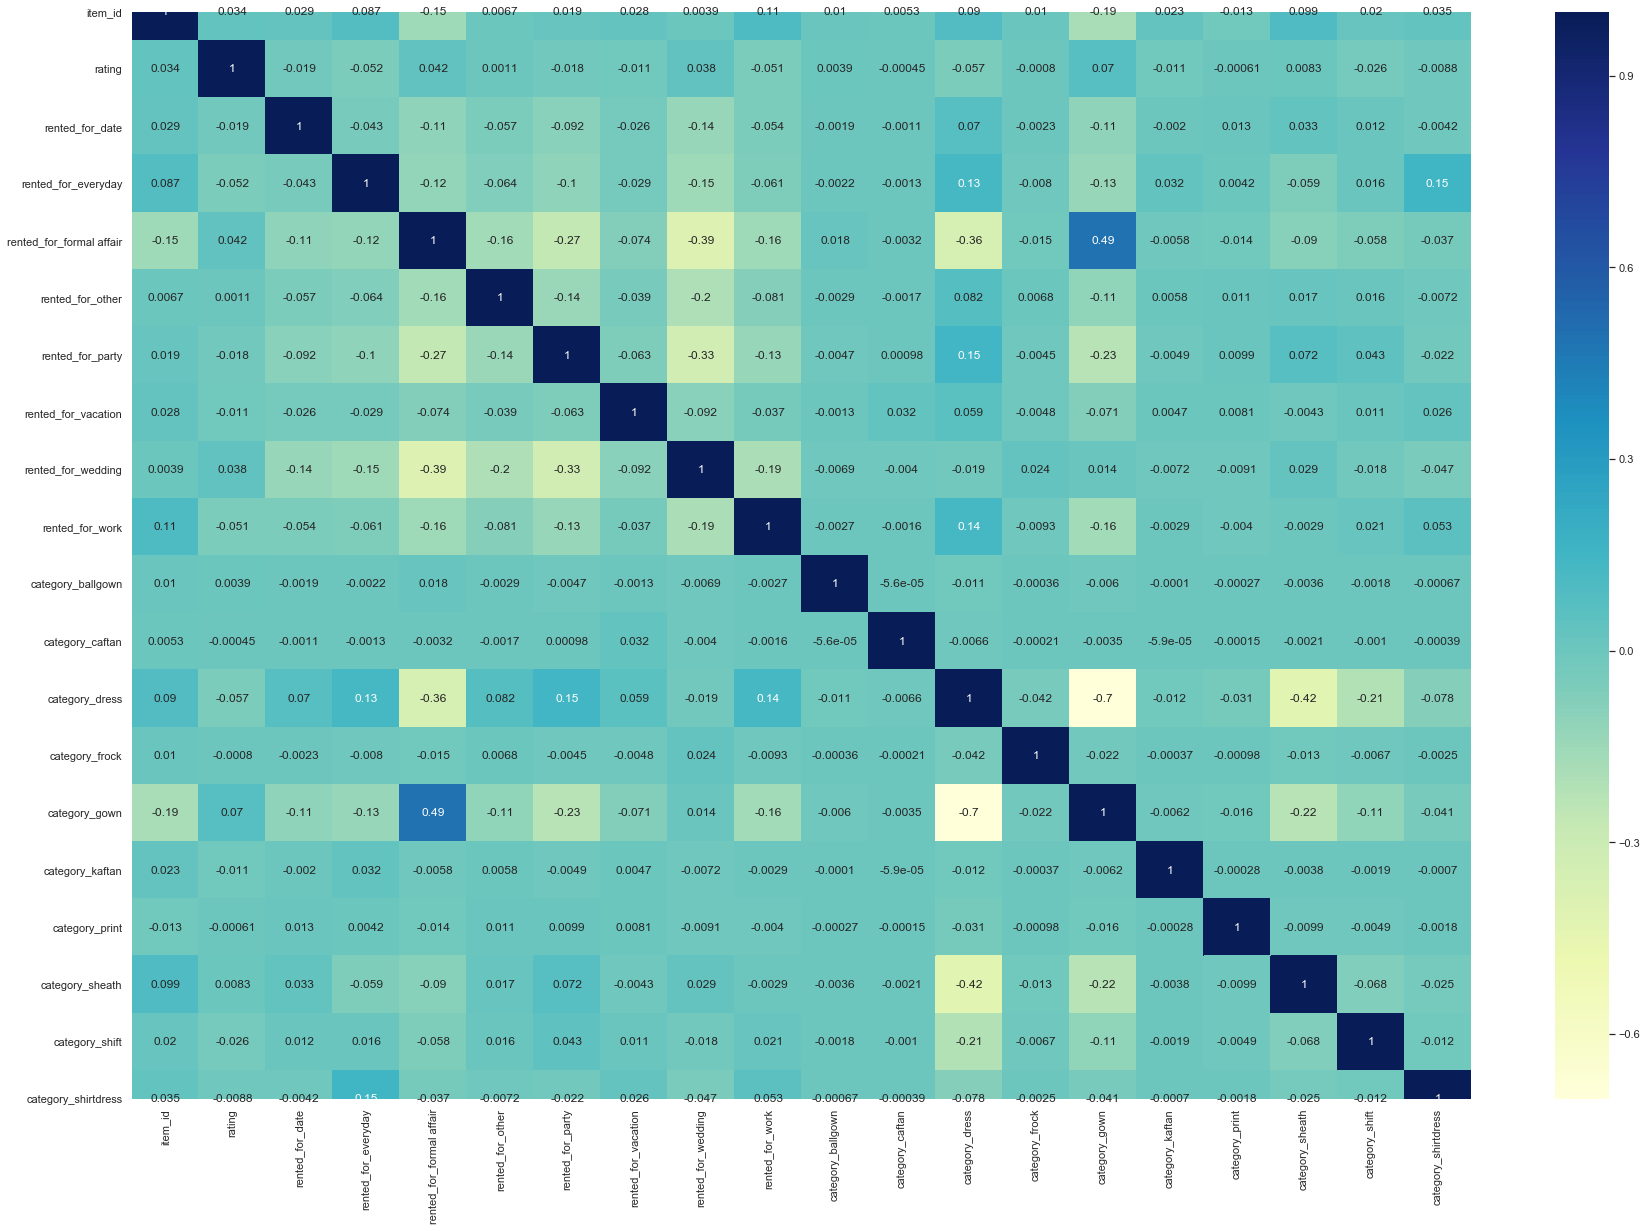

In [233]:
sns.set(rc={'figure.figsize':(30,20)})
sns.heatmap(dress_corr, xticklabels=dress_corr.columns, yticklabels=dress_corr.columns, annot=True, cmap="YlGnBu")

In [234]:
user_df = df[['user_id', 'bust_size', 'cup_size', 'body_type', 'weight', 'height', 'age']].copy()

In [235]:
user_dummies = pd.get_dummies(user_df)

In [236]:
user_corr = user_dummies.corr()

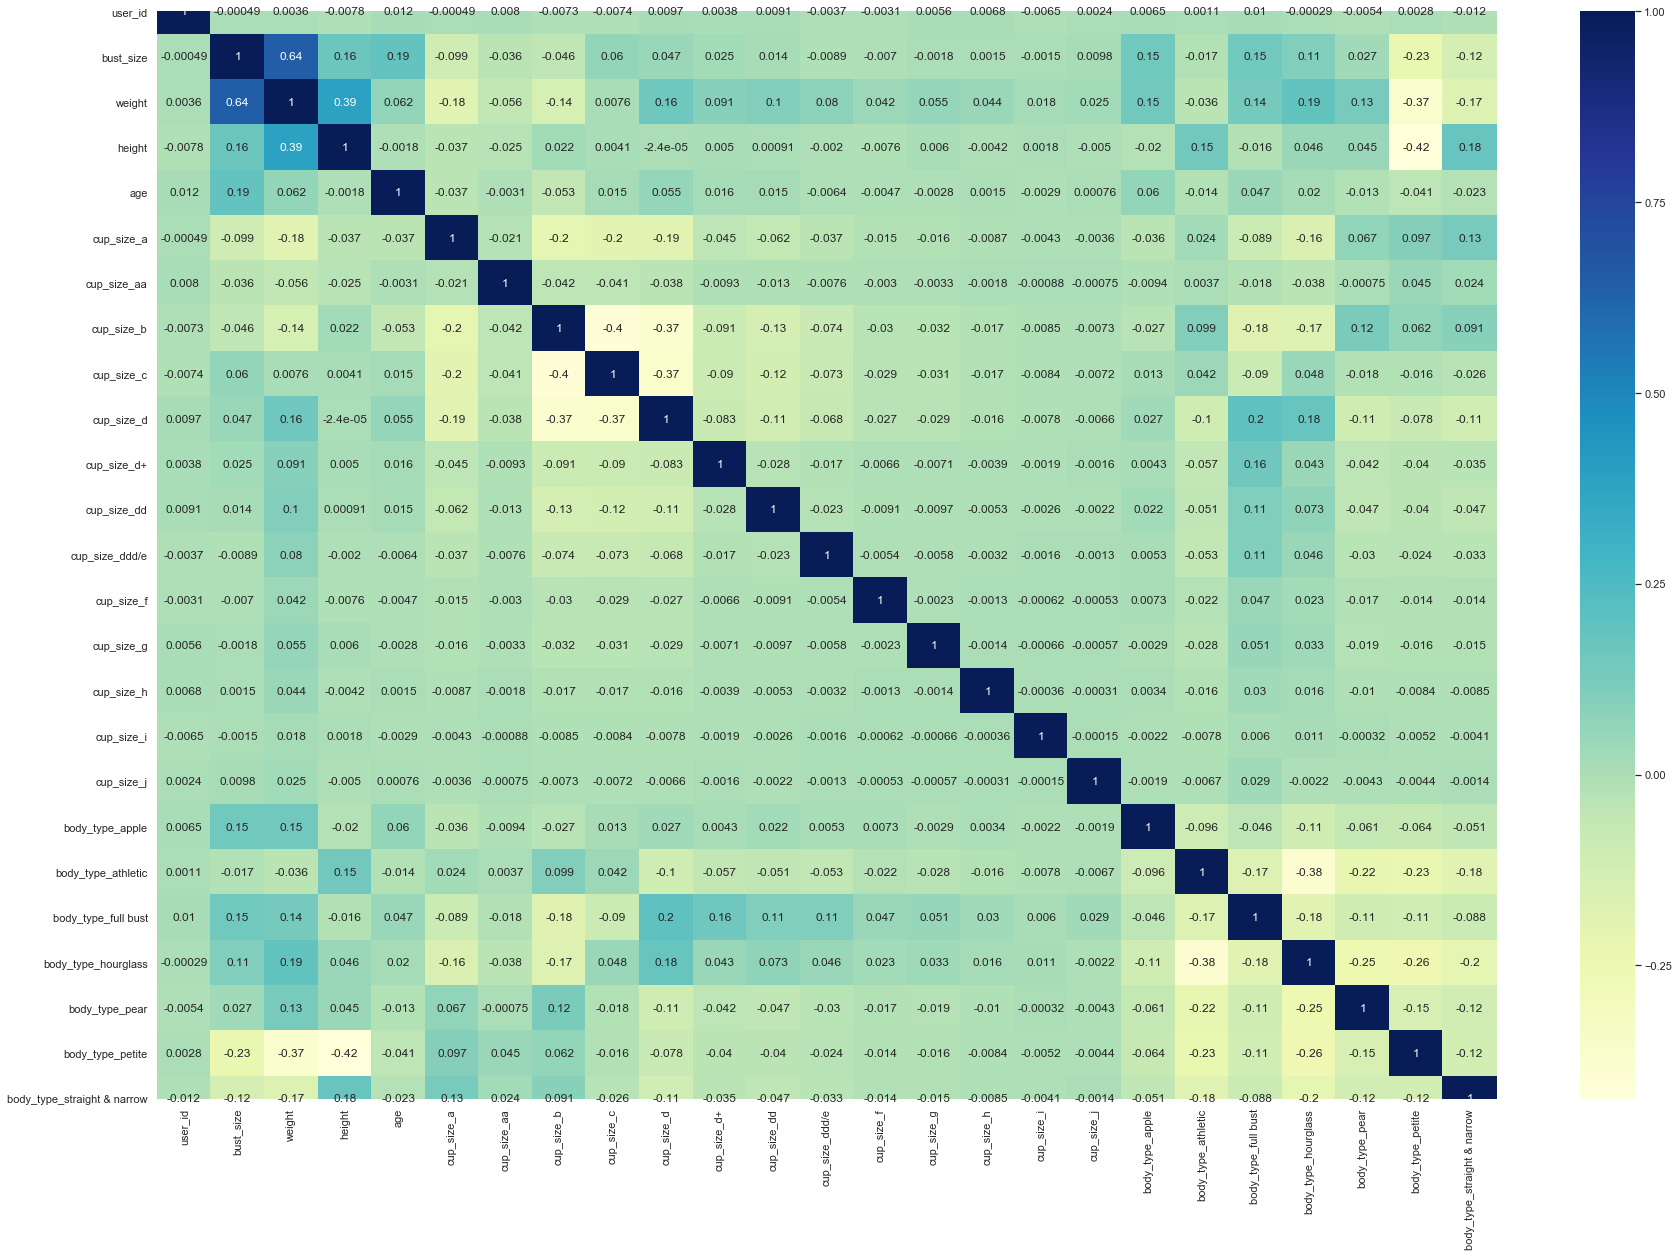

In [237]:
sns.set(rc={'figure.figsize':(30,20)})
sns.heatmap(user_corr, xticklabels=user_corr.columns, yticklabels=user_corr.columns, annot=True, cmap="YlGnBu")

In [247]:
condition_u = dress_big_ratings_df['user_count'] > 15
condition_i = dress_big_ratings_df['item_count'] > 15
condition_u2 = dress_big_ratings_df['user_count'] < 25
condition_i2 = dress_big_ratings_df['item_count'] < 15

In [241]:
dress_items_dummies.head()

,item_id,rating,rented_for_date,rented_for_everyday,rented_for_formal affair,rented_for_other,rented_for_party,rented_for_vacation,rented_for_wedding,rented_for_work,category_ballgown,category_caftan,category_dress,category_frock,category_gown,category_kaftan,category_print,category_sheath,category_shift,category_shirtdress
1,153475,10.0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,126335,8.0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4,616682,10.0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0
5,364092,8.0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
6,568429,10.0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


In [242]:
dress_items_dummies['item_count'] = dress_items_dummies.groupby(['item_id'])['item_id'].transform('count')

In [243]:
dress_items_dummies.head()

,item_id,rating,rented_for_date,rented_for_everyday,rented_for_formal affair,rented_for_other,rented_for_party,rented_for_vacation,rented_for_wedding,rented_for_work,...,category_caftan,category_dress,category_frock,category_gown,category_kaftan,category_print,category_sheath,category_shift,category_shirtdress,item_count
1,153475,10.0,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,381
3,126335,8.0,0,0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1526
4,616682,10.0,0,0,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,89
5,364092,8.0,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,21
6,568429,10.0,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,3


In [248]:
small_dress_items = dress_items_dummies[condition_i2]

In [249]:
small_dress_items.shape

(11480, 21)

In [250]:
cosine_similarity(small_dress_items)

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]])

In [251]:
small_dress_items.shape

(11480, 21)

In [252]:
small_dress_items['item_id'].value_counts()

861118     14
1438673    14
597613     14
1584972    14
1222019    14
           ..
997357      1
874239      1
261938      1
542595      1
247960      1
Name: item_id, Length: 1759, dtype: int64

In [255]:
df.head()

,fit,user_id,bust_size,item_id,weight,rating,rented_for,review_text,body_type,review_summary,category,height,size,age,cup_size,item_count
0,fit,420272,34,2260466,137,10.0,vacation,An adorable romper! Belt and zipper were a lit...,hourglass,So many compliments!,romper,68.0,14,28.0,d,19
1,fit,273551,34,153475,132,10.0,other,I rented this dress for a photo shoot. The the...,straight & narrow,I felt so glamourous!!!,gown,66.0,12,36.0,b,381
3,fit,909926,34,126335,135,8.0,formal affair,I rented this for my company's black tie award...,pear,Dress arrived on time and in perfect condition.,dress,65.0,8,34.0,c,1526
4,fit,151944,34,616682,145,10.0,wedding,I have always been petite in my upper body and...,athletic,Was in love with this dress !!!,gown,69.0,12,27.0,b,89
5,fit,734848,32,364092,138,8.0,date,Didn't actually wear it. It fit perfectly. The...,athletic,Traditional with a touch a sass,dress,68.0,8,45.0,b,21


In [257]:
##regroup categories (reduce from 68 to 7)
recat1 = df.replace(['dress', 'sheath', 'shirtdress', 'shift', 'ballgown', 'frock', 'kaftan', 'caftan', 'gown', 'print'], 'dresses')
recat2 = recat1.replace(['romper', 'jumpsuit', 'overalls', 'combo', 'suit'], 'jumpsuits')
recat3 = recat2.replace(['jogger', 'trousers', 'tight', 'jeans', 'sweatpants', 'leggings', 'pants', 'culottes', 'legging', 'pant', 'culotte', 'trouser'], 'pants')
recat4 = recat3.replace(['sweater', 'duster', 'cardigan', 'sweatshirt', 'pullover', 'turtleneck', 'hoodie', 'sweatershirt'], 'sweaters')
recat5 = recat4.replace(['jacket', 'coat', 'trench', 'cape', 'bomber', 'blazer', 'vest', 'poncho', 'down', 'parka', 'peacoat', 'overcoat'], 'outerwear')
recat6 = recat5.replace(['top,', 'shirt', 'blouse', 'tank', 'tunic', 'knit', 'tee', 'henley', 'blouson', 't-shirt', 'kimono', 'cami', 'crewneck', 'buttondown', 'for'], 'tops')
recat7 = recat6.replace(['mini', 'skirt', 'maxi','midi', 'skirts', 'skort'], 'skirts')
recat8 = recat7.replace(['top'], 'tops')

##rename recategorized df variable
recat_df = recat8

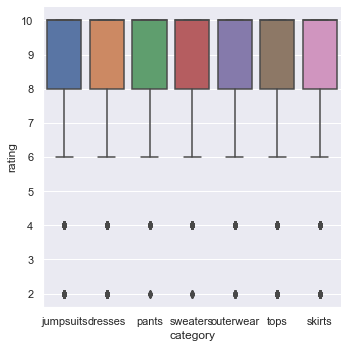

In [261]:
sns.set(rc={'figure.figsize':(30,20)})
sns.catplot(x="category", y="rating", kind="box", data=recat_df)


In [262]:
# non_normal = ['displacement', 'horsepower', 'weight']
# for feat in non_normal:
#     data[feat] = data[feat].map(lambda x: np.log(x))
# pd.plotting.scatter_matrix(data[x_cols], figsize=(10,12));

In [265]:
small_dress_items.head()

,item_id,rating,rented_for_date,rented_for_everyday,rented_for_formal affair,rented_for_other,rented_for_party,rented_for_vacation,rented_for_wedding,rented_for_work,...,category_caftan,category_dress,category_frock,category_gown,category_kaftan,category_print,category_sheath,category_shift,category_shirtdress,item_count
6,568429,10.0,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,3
27,1739627,10.0,0,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,13
41,1542652,8.0,0,0,0,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,10
42,1406963,4.0,0,0,0,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,6
49,1829354,8.0,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,8


In [287]:
items_df_dress = small_dress_items.groupby(['item_id']).mean()

In [289]:
items_df_dress = items_df_dress.drop(['item_count'], axis=1)

In [272]:
items_df_dress = items_df_dress.reset_index()

In [279]:
items_df_dress['log_rating'] = items_df_dress['rating'].map(lambda x: np.log(x))

In [290]:
items_df_dress.head()

,rating,rented_for_date,rented_for_everyday,rented_for_formal affair,rented_for_other,rented_for_party,rented_for_vacation,rented_for_wedding,rented_for_work,category_ballgown,category_caftan,category_dress,category_frock,category_gown,category_kaftan,category_print,category_sheath,category_shift,category_shirtdress
item_id,,,,,,,,,,,,,,,,,,,
170762,9.000000,0.0,0.0,0.400000,0.0,0.100000,0.0,0.500000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
189303,8.909091,0.0,0.0,0.363636,0.0,0.363636,0.0,0.272727,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
195406,9.000000,0.0,0.0,0.500000,0.0,0.000000,0.0,0.500000,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
200640,10.000000,0.0,0.5,0.000000,0.0,0.000000,0.0,0.500000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
201534,9.000000,0.0,0.0,0.833333,0.0,0.000000,0.0,0.166667,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [282]:
items_logged = items_df_dress.drop(['rating'], axis=1)

In [283]:
items_logged.head()

,item_id,rented_for_date,rented_for_everyday,rented_for_formal affair,rented_for_other,rented_for_party,rented_for_vacation,rented_for_wedding,rented_for_work,category_ballgown,category_caftan,category_dress,category_frock,category_gown,category_kaftan,category_print,category_sheath,category_shift,category_shirtdress,log_rating
0,170762,0.0,0.0,0.400000,0.0,0.100000,0.0,0.500000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.197225
1,189303,0.0,0.0,0.363636,0.0,0.363636,0.0,0.272727,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.187072
2,195406,0.0,0.0,0.500000,0.0,0.000000,0.0,0.500000,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.197225
3,200640,0.0,0.5,0.000000,0.0,0.000000,0.0,0.500000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.302585
4,201534,0.0,0.0,0.833333,0.0,0.000000,0.0,0.166667,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.197225


In [291]:
items_df_dress.shape

(1759, 19)

In [285]:
cosine_similarity(items_logged)

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]])

In [293]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
dress_scaled = scaler.fit_transform(items_df_dress)

array([[0.875     , 0.        , 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.86363636, 0.        , 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.875     , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.65      , 0.2       , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.9375    , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.69230769, 0.        , 0.69230769, ..., 0.        , 0.        ,
        0.        ]])

In [297]:
# Convert into a DataFrame
scaled_df = pd.DataFrame(dress_scaled, columns=items_df_dress.columns, index=items_df_dress.index)
scaled_df.head()

,rating,rented_for_date,rented_for_everyday,rented_for_formal affair,rented_for_other,rented_for_party,rented_for_vacation,rented_for_wedding,rented_for_work,category_ballgown,category_caftan,category_dress,category_frock,category_gown,category_kaftan,category_print,category_sheath,category_shift,category_shirtdress
item_id,,,,,,,,,,,,,,,,,,,
170762,0.875000,0.0,0.0,0.400000,0.0,0.100000,0.0,0.500000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
189303,0.863636,0.0,0.0,0.363636,0.0,0.363636,0.0,0.272727,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
195406,0.875000,0.0,0.0,0.500000,0.0,0.000000,0.0,0.500000,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
200640,1.000000,0.0,0.5,0.000000,0.0,0.000000,0.0,0.500000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
201534,0.875000,0.0,0.0,0.833333,0.0,0.000000,0.0,0.166667,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [298]:
cosine_similarity(scaled_df)

array([[1.        , 0.97155965, 0.54628312, ..., 0.41075946, 0.53233067,
        0.28845997],
       [0.97155965, 1.        , 0.49411976, ..., 0.43252135, 0.50359386,
        0.29152334],
       [0.54628312, 0.49411976, 1.        , ..., 0.42291458, 0.97418948,
        0.28332139],
       ...,
       [0.41075946, 0.43252135, 0.42291458, ..., 1.        , 0.49056047,
        0.23212961],
       [0.53233067, 0.50359386, 0.97418948, ..., 0.49056047, 1.        ,
        0.2887537 ],
       [0.28845997, 0.29152334, 0.28332139, ..., 0.23212961, 0.2887537 ,
        1.        ]])

### cosine similarity for knn and svd

In [299]:
from surprise import Dataset
from surprise.model_selection import train_test_split

In [304]:
# A reader is still needed but only the rating_scale param is requiered.
reader = Reader(rating_scale=(0, 1))

# The columns must correspond to user id, item id and ratings (in that order).
data = Dataset.load_from_df(scaled_df)

TypeError: load_from_df() missing 1 required positional argument: 'reader'

In [300]:
# Split into train and test set
trainset, testset = train_test_split(scaled_df, test_size=0.25)

AttributeError: 'DataFrame' object has no attribute 'raw_ratings'

In [305]:
import numpy as np
from sklearn.neighbors import NearestNeighbors



In [307]:
neigh = NearestNeighbors()
neigh.fit(scaled_df)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='minkowski',
                 metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                 radius=1.0)

In [311]:
neigh.kneighbors(X=None, n_neighbors=2, return_distance=False)

array([[ 153,  978],
       [  46,  684],
       [  33, 1284],
       ...,
       [1266,  850],
       [1219, 1262],
       [ 319, 1577]])

In [314]:
A = neigh.kneighbors_graph(scaled_df)
A.toarray()

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [317]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
recat_df['rating'] = scaler.fit_transform(recat_df['rating'])

ValueError: Expected 2D array, got 1D array instead:
array=[10. 10.  8. ...  6. 10. 10.].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [318]:
dress_ratings_df.head()

,user_id,item_id,rating
6,336066,568429,10.0
20,661150,900878,10.0
27,610914,1739627,10.0
41,606693,1542652,8.0
42,126879,1406963,4.0


In [321]:
a = dress_ratings_df[['rating']]

In [322]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaled_a = scaler.fit_transform(a)

In [323]:
a_df = pd.DataFrame(scaled_a, columns=a.columns, index=a.index)

In [324]:
dress_ratings_df['scaled_rating'] = a_df['rating']

/Users/andrewtriola/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [326]:
dress_ratings_scaled = dress_ratings_df.drop(['rating'], axis=1)

In [327]:
dress_ratings_scaled.head()

,user_id,item_id,scaled_rating
6,336066,568429,1.00
20,661150,900878,1.00
27,610914,1739627,1.00
41,606693,1542652,0.75
42,126879,1406963,0.25


In [329]:
# A reader is still needed but only the rating_scale param is requiered.
reader = Reader(rating_scale=(0, 1))

# The columns must correspond to user id, item id and ratings (in that order).
data = Dataset.load_from_df(dress_ratings_scaled,reader)

In [331]:
# Split into train and test set
trainset, testset = train_test_split(data, test_size=0.25)

In [343]:
# We'll use the famous SVD algorithm.
algo = SVD(n_epochs=10, lr_all=0.005, reg_all=0.6)
# Train the algorithm on the trainset, and predict ratings for the testset
algo.fit(trainset)
svd_predictions1 = algo.test(testset)

# Then compute RMSE
accuracy.rmse(svd_predictions1)

RMSE: 0.1913


0.19129948764341323

In [333]:
### grid search ###

param_grid = {'n_epochs': [5, 10], 'lr_all': [0.002, 0.005],
              'reg_all': [0.4, 0.6]}
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3)

gs.fit(data)

# best RMSE score
print(gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

0.19142235764597326
{'n_epochs': 10, 'lr_all': 0.005, 'reg_all': 0.6}


In [344]:
svd_predictions1[0]

Prediction(uid=398133, iid=1026404, r_ui=1.0, est=0.8806240739776017, details={'was_impossible': False})

In [347]:
svd_list = []
for i in svd_predictions1:
    svd_list.append((i[2], i[3]))


In [350]:
svd_list[1111]

(1.0, 0.8807494275379495)

In [351]:
svd1_df = pd.DataFrame(svd_list, columns=['r_ui', 'est'])

In [352]:
svd1_df.head()

,r_ui,est
0,1.0,0.880624
1,1.0,0.899068
2,1.0,0.904363
3,1.0,0.865252
4,1.0,0.906159


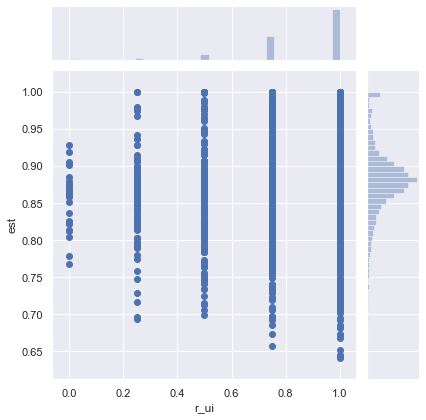

In [353]:
sns.jointplot(x='r_ui',y='est',data=svd1_df)

In [363]:
df[df['item_id'] == 541999].head(10)

,fit,user_id,bust_size,item_id,weight,rating,rented_for,review_text,body_type,review_summary,category,height,size,age,cup_size,item_count
20714,fit,679869,36,541999,147,10.0,formal affair,"I usually wear a 6, but the 8 fit just right. ...",athletic,The event was a wonderful night out without ki...,gown,67.0,16,47.0,c,44
27863,fit,364682,38,541999,210,10.0,wedding,i was a lady in waiting for the bride so i wa...,full bust,I got so many compliments on this dress.,gown,66.0,45,29.0,d,44
28126,fit,295440,34,541999,115,10.0,wedding,It was a little longer than I would have liked...,petite,Amazing dress!!! Wish I could wear it again!!,gown,64.0,4,30.0,a,44
28492,large,147499,36,541999,163,8.0,wedding,(Reviewing for my sister who is pictured) she ...,pear,Longer than expected.,gown,65.0,35,25.0,b,44
36669,fit,248703,32,541999,150,10.0,formal affair,"I was so hesitant to try RTR, but hate shoppin...",full bust,This was the BEST dress I have ever worn!!,gown,65.0,16,27.0,ddd/e,44
38907,fit,649675,32,541999,124,10.0,formal affair,All of the reviews I read said this dress fits...,petite,Gala,gown,62.0,3,27.0,b,44
40074,fit,717858,34,541999,126,8.0,wedding,This dress was very flattering and elegant. Th...,athletic,Flattering & Elegant Dress,gown,68.0,5,28.0,b,44
54101,fit,232648,34,541999,115,10.0,wedding,Rented this for a black tie wedding reception....,athletic,Comfortable and fabulous!,gown,62.0,4,28.0,c,44
54576,fit,942309,32,541999,105,8.0,wedding,I really loved this dress and it worked perfec...,petite,Simple yet Elegant,gown,62.0,1,30.0,b,44
59491,fit,415755,34,541999,140,10.0,wedding,This hugged the body perfectly and flared star...,pear,"This showed all my curves, but was still very ...",gown,69.0,12,65.0,c,44


In [362]:
df[df['category'] == 'gown'].head()

,fit,user_id,bust_size,item_id,weight,rating,rented_for,review_text,body_type,review_summary,category,height,size,age,cup_size,item_count
1,fit,273551,34,153475,132,10.0,other,I rented this dress for a photo shoot. The the...,straight & narrow,I felt so glamourous!!!,gown,66.0,12,36.0,b,381
4,fit,151944,34,616682,145,10.0,wedding,I have always been petite in my upper body and...,athletic,Was in love with this dress !!!,gown,69.0,12,27.0,b,89
9,fit,154309,32,1729232,114,10.0,formal affair,The dress was very flattering and fit perfectl...,petite,This dress was everything! It was perfect for ...,gown,63.0,1,33.0,b,242
14,fit,721308,34,123793,118,10.0,formal affair,"Fit great, super flattering",athletic,Stunning gown. Wore this for heart ball and re...,gown,65.0,2,32.0,b,1354
19,small,16800,34,1229740,135,10.0,formal affair,"super cute, 8 was super tight so i wore the 10...",petite,gala ready,gown,66.0,21,33.0,c,161
